In [19]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

# Ensures inline plotting
%matplotlib inline

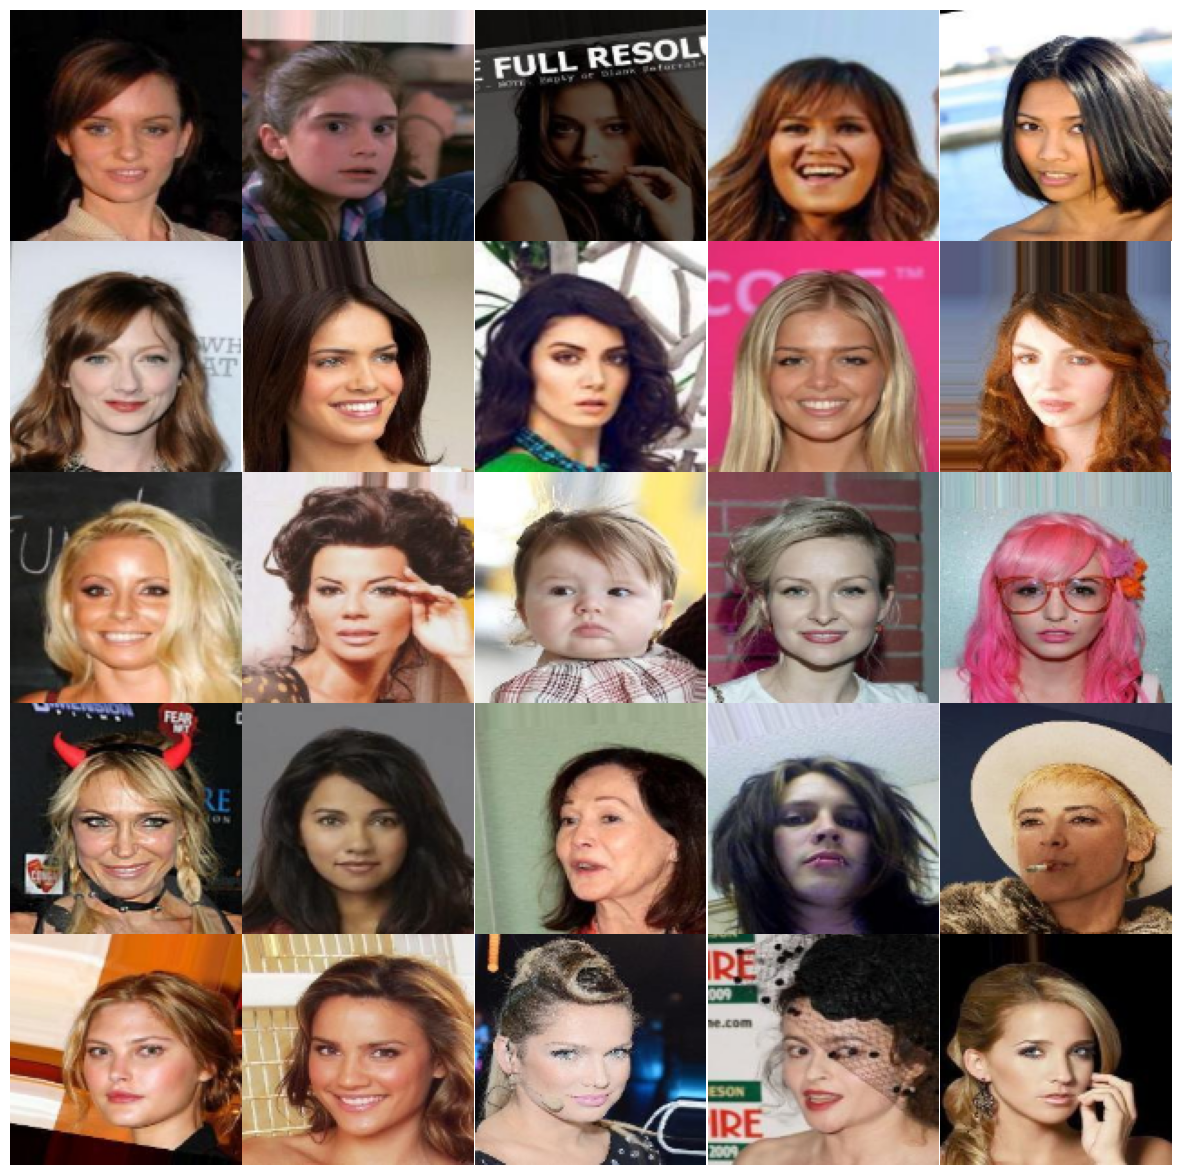

In [20]:
multipleImages = glob.glob(r"E:\Projets\Datasets - Pytorch\Gender Faces\Train\Female\**")
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

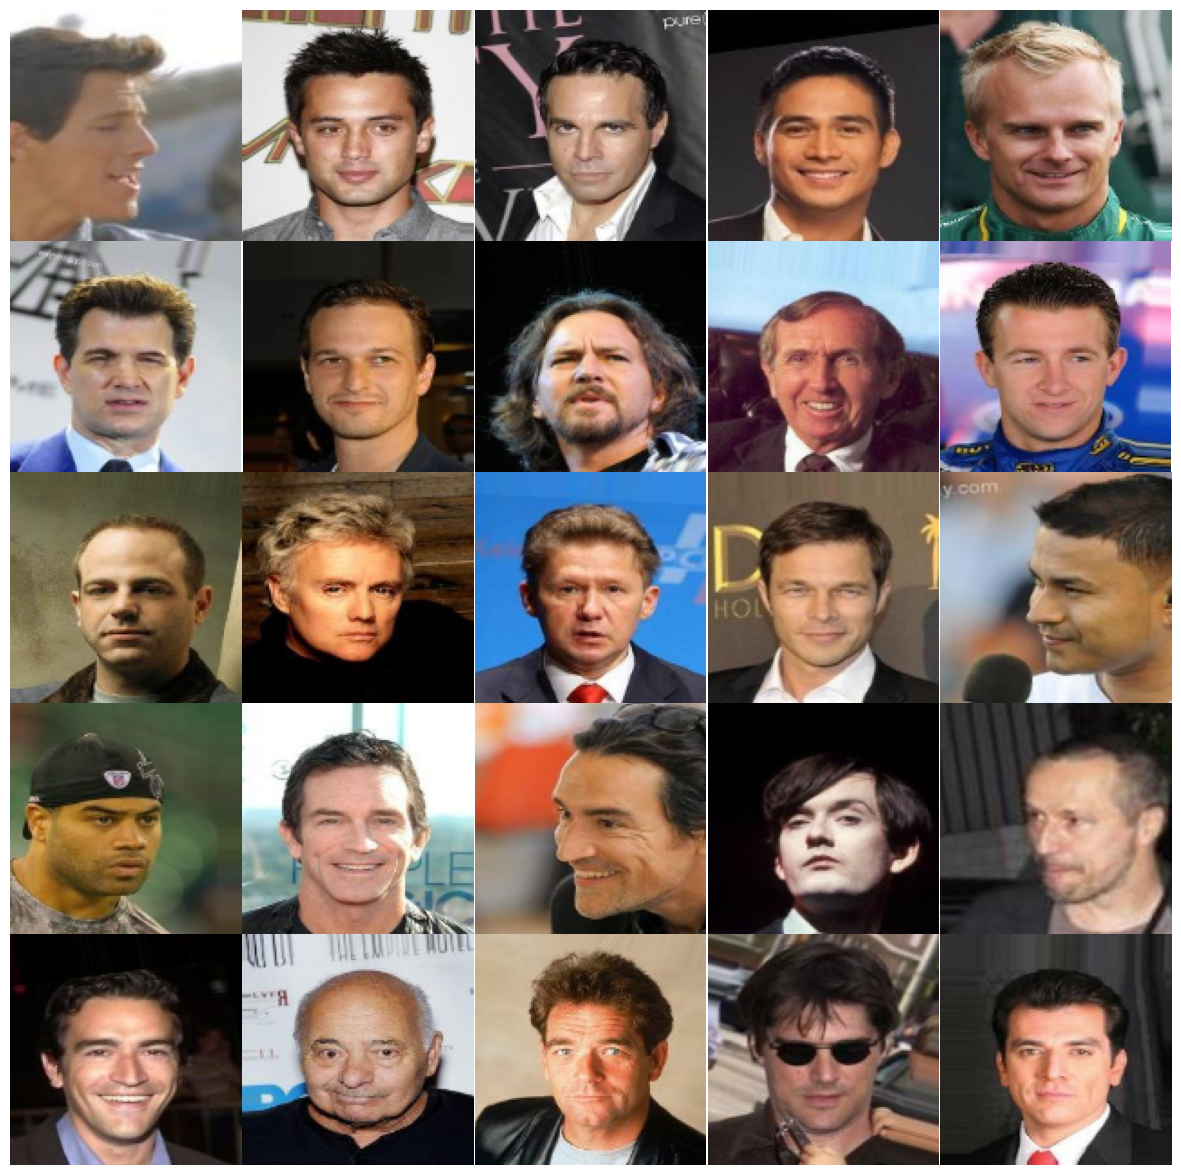

In [21]:
multipleImages = glob.glob(r"E:\Projets\Datasets - Pytorch\Gender Faces\Train\Male\**")
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

# DataLoaders

In [22]:
# Folder Paths
train_path = "E:\Projets\Datasets - Pytorch\Gender Faces\Train"
val_path = "E:\Projets\Datasets - Pytorch\Gender Faces\Validation"
test_path = "E:\Projets\Datasets - Pytorch\Gender Faces\Test"

#Tensor Datset


data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root= train_path , transform= data_transforms)
val_dataset = datasets.ImageFolder(root= val_path , transform= data_transforms)
test_dataset = datasets.ImageFolder(root= test_path , transform= data_transforms)

trainLoader = DataLoader(train_dataset , shuffle= True , batch_size= 32)
testLoader = DataLoader(test_dataset , shuffle= True , batch_size= 32)
valLoader = DataLoader(val_dataset , shuffle= True , batch_size= 32)



In [54]:
class GenderModel(nn.Module):
    def __init__(self):
        super(GenderModel, self).__init__()

        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=11, stride=1, padding=1)
        self.Pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=7, stride=1, padding=1)
        self.Pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.BN1 = nn.BatchNorm2d(64)
        self.Dropout2d = nn.Dropout2d(0.3)

        self.Conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=1)
        self.Pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.Pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.BN2 = nn.BatchNorm2d(256)

        self.Conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.Pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.BN3 = nn.BatchNorm2d(512)

        self.Pool6 = nn.AdaptiveAvgPool2d((1, 1))  

        self.FC1 = nn.Linear(512, 1024)
        self.Dropout = nn.Dropout(0.3)
        self.BN4 = nn.BatchNorm1d(1024)

        self.FC2 = nn.Linear(1024, 512)
        self.FC3 = nn.Linear(512, 256)

        self.BN5 = nn.BatchNorm1d(256)

        self.FC4 = nn.Linear(256, 128)
        self.FC5 = nn.Linear(128, 64)

        self.BN6 = nn.BatchNorm1d(64)

        self.Output = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.Conv1(x))
        x = self.Pool1(x)

        x = F.relu(self.Conv2(x))
        x = self.Pool2(x)

        x = self.Dropout2d(x)
        x = self.BN1(x)

        x = F.relu(self.Conv3(x))
        x = self.Pool3(x)

        x = F.relu(self.Conv4(x))
        x = self.Pool4(x)

        x = self.Dropout2d(x)
        x = self.BN2(x)

        x = F.relu(self.Conv5(x))
        x = self.Pool5(x)

        x = self.Dropout2d(x)
        x = self.BN3(x)

        # x = F.relu(self.Conv6(x))
        x = self.Pool6(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Changed from veiw to view

        # print(x.shape)  # Debugging output shape

        x = F.leaky_relu(self.FC1(x))
        x = self.Dropout(x)
        x = self.BN4(x)

        x = F.leaky_relu(self.FC2(x))
        x = F.leaky_relu(self.FC3(x))

        x = self.Dropout(x)
        x = self.BN5(x)

        x = F.leaky_relu(self.FC4(x))
        x = F.leaky_relu(self.FC5(x))

        x = self.Dropout(x)
        x = self.BN6(x)

        x = torch.sigmoid(self.Output(x))

        return x


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

GenMod = GenderModel()

GenMod.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GenMod.parameters() , lr= 0.0001 , weight_decay=1e-4)        

print(GenMod)

GenderModel(
  (Conv1): Conv2d(3, 16, kernel_size=(11, 11), stride=(1, 1), padding=(1, 1))
  (Pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2): Conv2d(16, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
  (Pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Dropout2d): Dropout2d(p=0.3, inplace=False)
  (Conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (Pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BN2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (Pool5): MaxPool2d(kerne

In [55]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GenMod.to(device)

# Early stopping and epochs
eps = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(eps):
    train_correct = 0
    train_total = 0
    running_loss = 0

    GenMod.train()

    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = GenMod(image)

        loss = criterion(outputs, label)
        l1_norm = sum(p.abs().sum() for p in GenMod.parameters())
        loss += 0.01 * l1_norm

        _, predicted = torch.max(outputs.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    avg_training_loss = running_loss / len(trainLoader)
    train_accuracy = (train_correct / train_total)
    train_losses.append(avg_training_loss)
    train_accuracies.append(train_accuracy)

    val_correct = 0
    val_total = 0
    val_running_loss = 0

    GenMod.eval()
    with torch.no_grad():
        for image, label in valLoader:
            image, label = image.to(device), label.to(device)
            outputs = GenMod(image)
            loss = criterion(outputs, label)
            val_running_loss += loss.item()  

            _, predicted = torch.max(outputs.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

    avg_val_loss = val_running_loss / len(valLoader)  
    val_accuracy = (val_correct / val_total)

    val_accuracies.append(val_accuracy)
    val_losses.append(avg_val_loss)

    # Print results
    print(f'Epoch: {epoch}, Train Loss: {avg_training_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch: 0, Train Loss: 91.3964, Train Accuracy: 0.63%, Val Loss: 0.5707, Val Accuracy: 0.76%
Epoch: 1, Train Loss: 12.3912, Train Accuracy: 0.78%, Val Loss: 0.6198, Val Accuracy: 0.69%
Epoch: 2, Train Loss: 5.1137, Train Accuracy: 0.78%, Val Loss: 0.6329, Val Accuracy: 0.68%
Epoch: 3, Train Loss: 1.1532, Train Accuracy: 0.76%, Val Loss: 0.6237, Val Accuracy: 0.68%


KeyboardInterrupt: 

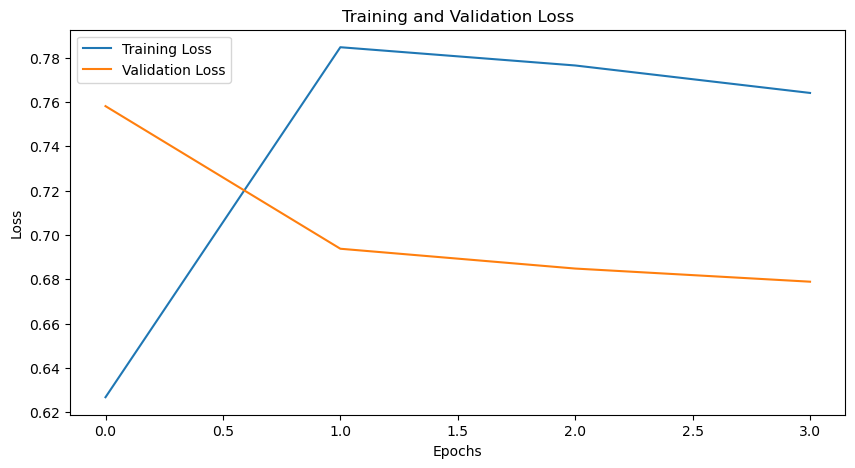

In [56]:

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Loss')
plt.plot(val_accuracies, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

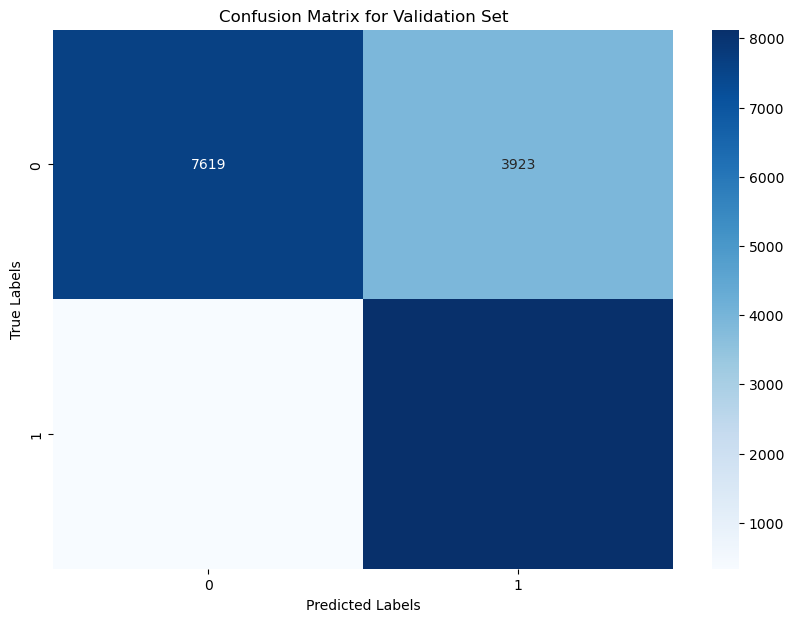

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store predictions and actual labels
all_preds = []
all_labels = []

# Switch model to evaluation mode
GenMod.eval()
with torch.no_grad():
    for image, label in testLoader:
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()
        
        # Get model output
        outputs = GenMod(image)
        
        # Get predicted classes
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(label.cpu().numpy())  # Move to CPU and convert to numpy

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Set')
plt.show()


In [60]:
from sklearn.metrics import f1_score ,accuracy_score
from sklearn.metrics import precision_score, recall_score

f1 = f1_score(all_labels, all_preds, average='weighted')  
precision = precision_score(all_labels, all_preds, average='weighted') 
recall = recall_score(all_labels, all_preds, average='weighted')  
accuracy = accuracy_score(all_labels , all_preds)
print(f'Accuracy Score: {accuracy:.4f} , F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Accuracy Score: 0.7871 , F1 Score: 0.7861, Precision: 0.8380, Recall: 0.7871
